In [2]:
import ugradio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import new_interf
from datetime import datetime, timedelta
import scipy.optimize
import astropy.constants as c
import astropy.units as u

No module named 'rtlsdr'


In [3]:
ugradio.timing.lst

<function ugradio.timing.lst(jd=None, lon=-122.257063)>

In [4]:
L = ugradio.nch.lat # latitude


In [5]:
sun_data = pd.read_csv('sun_data2.csv')
sun_trunc = sun_data[2100:]
sun_volts = np.array(sun_trunc['Voltages'])
sun_times = np.array(sun_trunc['Times'])
#print(datetime.utcfromtimestamp(moon_times[0]).strftime('%Y-%m-%d %H:%M:%S'), "in UTC")
def utc_to_local(unix_time):
    utc_dt = datetime.utcfromtimestamp(unix_time)
    time = utc_dt - timedelta(hours=8)
    tJ= ugradio.timing.julian_date(unix_time)
    return time.strftime('%Y-%m-%d %H:%M:%S'), tJ
t,tJ = utc_to_local(sun_times[2100])
lst = ugradio.timing.lst(tJ)
print(t, "local time", tJ, "Julian time")

#print(moon_times[0], "time of observation in bullshit unix")
sun_times -= sun_times[0]  # this is shorthand for moontime = itself minus moontime[0]
dt = sun_times[1] - sun_times[0]  # this is the time step between samples
sun_volts-= sun_volts.mean()

2022-03-30 13:48:30 local time 2459669.408681566 Julian time


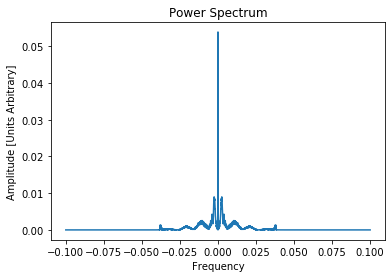

In [6]:
voltage_spectrum = np.fft.fft(sun_volts)
voltage_spectrum[0] = 0 # this is the same as subtracting the mean in the timeseries data 
power_spectrum = np.abs(voltage_spectrum)**2
frequencies = np.fft.fftfreq(len(power_spectrum), dt)

plt.figure()
plt.title("Power Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Amplitude [Units Arbitrary]")
plt.plot(np.fft.fftshift(frequencies), np.fft.fftshift(power_spectrum)) # shifting the arrays to read correctly
plt.show()

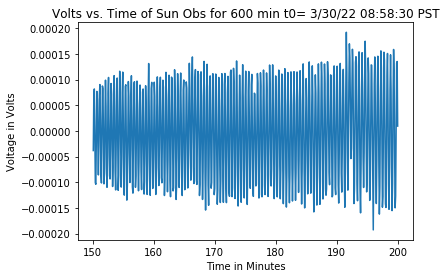

In [74]:
cond = (sun_times/60 > 150) & (sun_times/60 < 200)

plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Sun Obs for 600 min t0= 3/30/22 08:58:30 PST")
plt.plot(sun_times[cond]/60, sun_volts[cond])
plt.show()

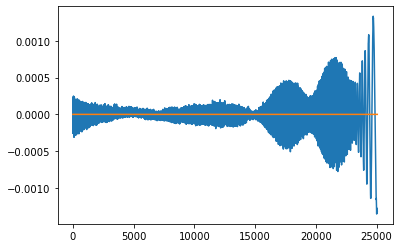

In [75]:
plt.figure()
plt.plot(sun_times, sun_volts)
p= np.polyfit(sun_times, sun_volts, 3)
fit = np.polyval(p, sun_times)
sun_volts-=fit
plt.plot(sun_times, fit)
plt.show()

In [65]:
RA = []
Dec = []
LST = []
for i in range(len(sun_times)):
    t_sun, tj_sun = utc_to_local(sun_times[i])
    RA_deg, dec = ugradio.coord.sunpos(tj_sun)
    precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
    RA.append(np.radians(precess_ra))
    Dec.append(np.radians(precess_dec))
    LST.append(ugradio.timing.lst(tj_sun))
    

#RA_deg, dec= ugradio.coord.sunpos() # wants julian date and it will return the RA and Dec
#print(RA_deg, "RA in degrees")
#arc_dec= 10.6/60 #converting arc min to degrees 
#arc_dec
#dec = -16 - arc_dec
#print(dec, "Dec in degrees")

#precess_ra, precess_dec = ugradio.coord.precess(RA_deg, dec)
#print("precess_ra is", precess_ra, "precess_dec is", precess_dec )
#RA = np.radians(precess_ra)
#Dec = np.radians(precess_dec)
#print("RA is", RA, "Dec", Dec )

In [66]:
print(lst)

0.5781742040615531


In [76]:
# guessing values for nu tau g to fit for the fringe amplitude

#guesses in meters
Bew = 20*u.m
Bns = 0*u.m
L = ugradio.nch.lat # latitude
wl = (c.c/(1.42*u.GHz)).to(u.m)  # wavelength in meters
# ntg = nu tao g
hs = RA*u.rad - LST*u.rad
ntg = ((Bew / wl *np.cos(Dec)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec))*np.cos(hs))
ntg_trunc = ntg[cond]
print(ntg_trunc.min(), ntg_trunc.max())

# now this needs to go into eq 12 (f is a function of A and B)

-86.98201688051586 -83.62134242667074


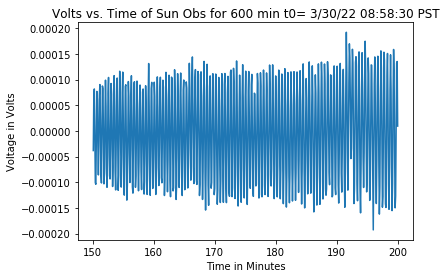

In [77]:
plt.figure()
plt.xlabel("Time in Minutes")
plt.ylabel("Voltage in Volts")
plt.title("Volts vs. Time of Sun Obs for 600 min t0= 3/30/22 08:58:30 PST")
plt.plot(sun_times[cond]/60, sun_volts[cond])
plt.show()

In [78]:
F = sun_volts[cond]
def model(n,A,B):
    return A*np.cos(2*np.pi*u.rad*n) + B*np.sin(2*np.pi*u.rad*n) 
    
def chisq(n,A,B):
    stuff = model(n,A,B)
    return np.sum((stuff-F)**2)

popt, pcov = scipy.optimize.curve_fit(model, ntg_trunc, F)
A, B = popt
print(A, B, pcov)

-3.4953143095923936e-06 -3.322787977943273e-06 [[ 2.89918629e-11 -1.59040868e-12]
 [-1.59040868e-12  2.79624824e-11]]


In [79]:
ntg_smooth = np.linspace(ntg_trunc.min(), ntg_trunc.max(), len(ntg_trunc)*5)

(-0.00019295106881630976, 0.0001924086088853746)

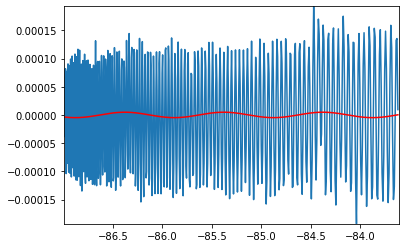

In [80]:
plt.figure()
plt.plot(ntg_trunc, F)
plt.plot(ntg_smooth, model(ntg_smooth, A, B), color='r')
plt.xlim(ntg_trunc.min()-0.01, ntg_trunc.max()+0.01)
plt.ylim(F.min(), F.max())

In [92]:
#guesses in meters
Bew_array = np.linspace(14,30,50)*u.m
Bns_array = np.linspace(0,6,50)*u.m
chisq_array = np.empty((50,50))
i = 0
j = 0

for Bew in Bew_array:
    for Bns in Bns_array:
        ntg = (Bew / wl *np.cos(Dec)) * np.sin(hs) + (Bns / wl * np.sin(L)*np.cos(Dec))*np.cos(hs)
        ntg_trunc = ntg[cond]

        popt, pcov = scipy.optimize.curve_fit(model, ntg_trunc, F)
        A, B = popt
        #print(i, j)
        chisq_array[i,j] = chisq(ntg_trunc,A,B)
        j+=1
    i+=1
    j=0

In [93]:
Bns.value

6.0

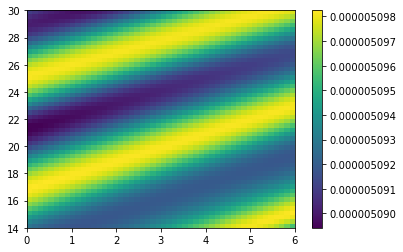

In [96]:
plt.figure()
plt.imshow(chisq_array,extent = [Bns_array.value.min(),Bns_array.value.max(),Bew_array.value.min(),Bew_array.value.max()], 
           aspect='auto', origin='lower')
plt.colorbar()
plt.show()

In [45]:
len(ntg_trunc)

750